In [54]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
con = sqlite3.connect("d:\proj\drucksachenbot\drucksachen.db")
df = pd.read_sql_query("select d.erscheinungstag, d.vorlangentyp, d.titel, "
                       "e.retweet_count, e.reply_count, e.like_count, e.quote_count "
                       "FROM drucksachen d "
                       "JOIN engagements e ON d.tweetid = e.tweetid", con)

In [3]:
df.head()

,erscheinungstag,vorlangentyp,titel,retweet_count,reply_count,like_count,quote_count
0,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Ausb...,1,0,0,0
1,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Unte...,0,0,0,0
2,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Stär...,0,0,0,0
3,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage GS T...,0,0,0,0
4,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage der ...,0,0,0,0


In [4]:
df.describe()

,retweet_count,reply_count,like_count,quote_count
count,5219.000000,5219.000000,5219.000000,5219.000000
mean,0.093121,0.011113,0.100594,0.116497
std,0.315300,0.135183,0.443899,0.332006
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,13.000000,2.000000


In [5]:
df['erscheinungstag_dt'] = pd.to_datetime(df['erscheinungstag'])

In [6]:
df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].corr()

,retweet_count,reply_count,like_count,quote_count
retweet_count,1.000000,0.182543,0.312345,-0.026761
reply_count,0.182543,1.000000,0.243248,0.069358
like_count,0.312345,0.243248,1.000000,0.148032
quote_count,-0.026761,0.069358,0.148032,1.000000


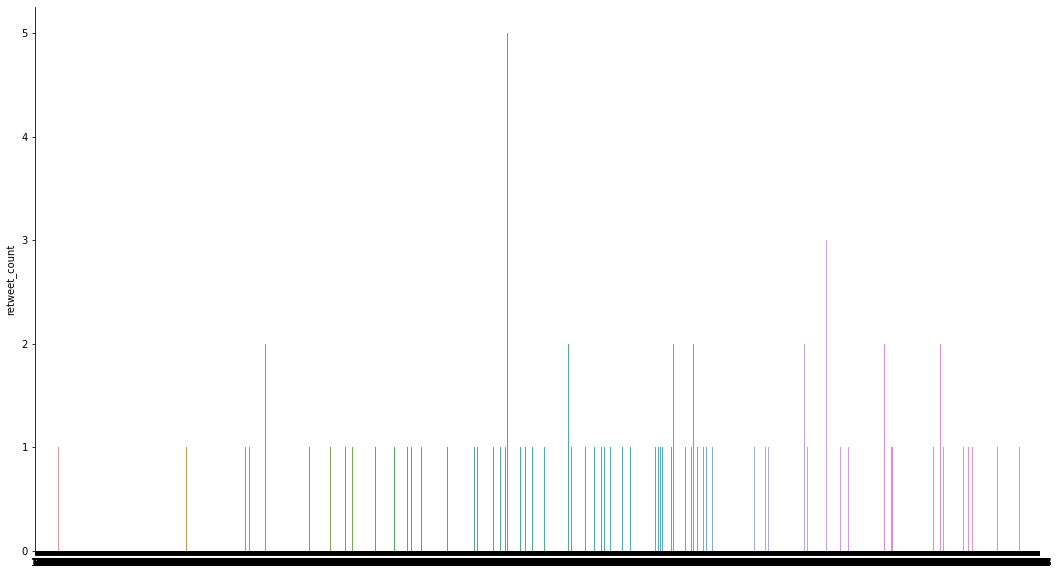

In [7]:
fig, ax1 = plt.subplots(figsize=(18, 10))
sns.barplot(data=df, x=df.index, y="retweet_count", ax=ax1)
sns.despine(fig)

In [8]:
df['engagement'] = df['retweet_count'] + df['reply_count'] + df['like_count'] + df['quote_count']

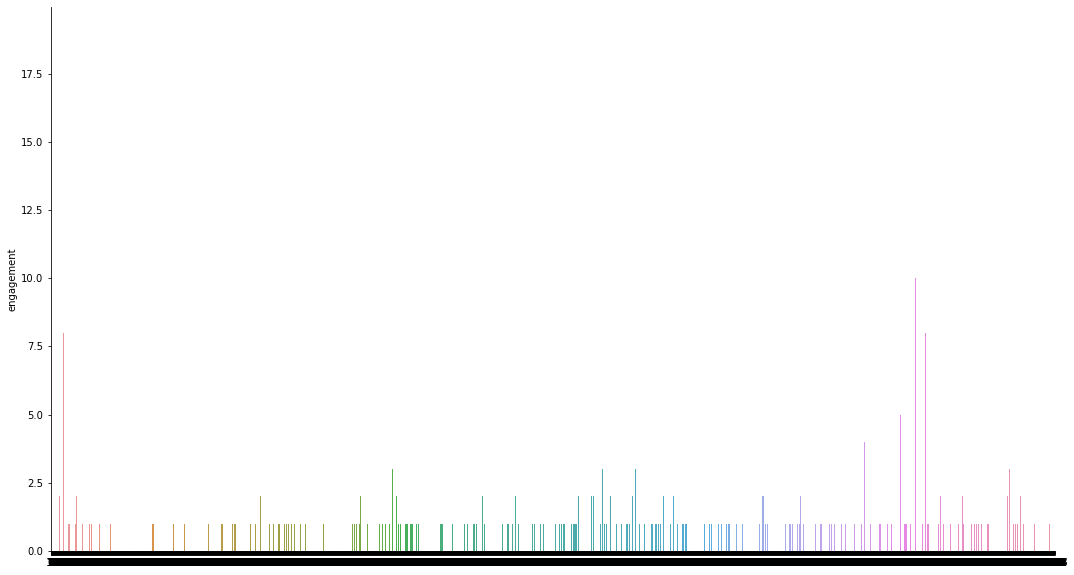

In [9]:
fig, ax1 = plt.subplots(figsize=(18, 10))
sns.barplot(data=df, x=df.index, y="engagement", ax=ax1)
sns.despine(fig)

In [10]:
df['vorlangentyp'].unique()

array(['Antwort', 'Neufassung', 'Beschlussdrucksache',
       'Informationsdrucksache', 'Anfrage', 'Entscheidung', 'Antrag',
       'Ergänzung', 'Haushaltsantrag', 'Stellungnahme'], dtype=object)

In [11]:
numerics = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'engagement']
df[['vorlangentyp'] + numerics].groupby('vorlangentyp').count()

,retweet_count,reply_count,like_count,quote_count,engagement
vorlangentyp,,,,,
Anfrage,848,848,848,848,848
Antrag,1328,1328,1328,1328,1328
Antwort,798,798,798,798,798
Beschlussdrucksache,522,522,522,522,522
Entscheidung,694,694,694,694,694
Ergänzung,14,14,14,14,14
Haushaltsantrag,673,673,673,673,673
Informationsdrucksache,172,172,172,172,172
Neufassung,160,160,160,160,160


In [12]:
engagement_by_type = df[['vorlangentyp'] + numerics].groupby('vorlangentyp').sum() / \
df[['vorlangentyp'] + numerics].groupby('vorlangentyp').count()

In [13]:
engagement_by_type

,retweet_count,reply_count,like_count,quote_count,engagement
vorlangentyp,,,,,
Anfrage,0.135613,0.017689,0.146226,0.113208,0.412736
Antrag,0.124247,0.016566,0.118223,0.167922,0.426958
Antwort,0.072682,0.015038,0.098997,0.112782,0.299499
Beschlussdrucksache,0.030651,0.001916,0.040230,0.045977,0.118774
Entscheidung,0.148415,0.010086,0.155620,0.182997,0.497118
Ergänzung,0.357143,0.071429,0.357143,0.142857,0.928571
Haushaltsantrag,0.002972,0.000000,0.013373,0.017831,0.034175
Informationsdrucksache,0.034884,0.000000,0.040698,0.075581,0.151163
Neufassung,0.081250,0.000000,0.093750,0.131250,0.306250


<AxesSubplot:ylabel='vorlangentyp'>

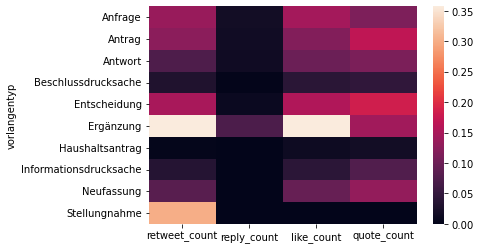

In [14]:
sns.heatmap(data=engagement_by_type[['retweet_count', 'reply_count', 'like_count', 'quote_count']])

In [15]:
df[df['vorlangentyp'] == 'Ergänzung']

,erscheinungstag,vorlangentyp,titel,retweet_count,reply_count,like_count,quote_count,erscheinungstag_dt,engagement
63,13.01.2021,Ergänzung,Ausbau der Lutherstraße zwischen Sallstraße un...,1,0,0,0,2021-01-13,1
125,19.01.2021,Ergänzung,Programmdrucksache zu den Infrastrukturmaßnahm...,0,0,0,0,2021-01-19,0
1221,10.03.2021,Ergänzung,1. Ergänzung zum Verwaltungsentwurf des Hausha...,0,0,0,0,2021-10-03,0
1436,16.03.2021,Ergänzung,2. Ergänzung zum Verwaltungsentwurf des Hausha...,0,0,0,0,2021-03-16,0
1702,30.03.2021,Ergänzung,\r\n1. Ergänzung zur Drucksache Nr. 0629/2021 ...,0,0,0,0,2021-03-30,0
2009,28.04.2021,Ergänzung,Änderungsanträge des Stadtbezirksrates Linden-...,0,0,0,0,2021-04-28,0
2060,30.04.2021,Ergänzung,Bushaltestelle „Kröpcke“ und Fahrbahnerneuerun...,0,0,0,0,2021-04-30,0
2377,26.05.2021,Ergänzung,Ausbau der Veloroute 08 aus der Innenstadt Han...,0,0,0,1,2021-05-26,1
2623,10.06.2021,Ergänzung,Antwort der Verwaltung auf die\r\nAnfrage Aufp...,1,0,0,0,2021-10-06,1
2723,18.06.2021,Ergänzung,"Bebauungsplan der Innenentwicklung Nr. 473, 2....",0,0,0,0,2021-06-18,0


In [16]:
df[df['vorlangentyp'] == 'Stellungnahme']

,erscheinungstag,vorlangentyp,titel,retweet_count,reply_count,like_count,quote_count,erscheinungstag_dt,engagement
1705,31.03.2021,Stellungnahme,Ausrüstung der Unterrichtsräume im Stadtbezirk...,0,0,0,0,2021-03-31,0
1791,14.04.2021,Stellungnahme,Dringlichkeitsantrag: Schaffung von betreutem ...,0,0,0,0,2021-04-14,0
3086,08.07.2021,Stellungnahme,Umwidmung der Nieschlagstraße zur Fahrradstraße,1,0,0,0,2021-08-07,1
3087,08.07.2021,Stellungnahme,Durchgängige Markierung des Fahrradschutzstrei...,1,0,0,0,2021-08-07,1
3090,08.07.2021,Stellungnahme,Umwidmung Otto-Wels-Straße zur Fahrradstraße,1,0,0,0,2021-08-07,1
3290,17.08.2021,Stellungnahme,Löschwasserversorgung im Lohweg\r\nSitzung des...,0,0,0,0,2021-08-17,0
3435,08.09.2021,Stellungnahme,Störfall beim Zementwerk Holcim/Höver\r\nSitzu...,0,0,0,0,2021-08-09,0
4078,19.10.2021,Stellungnahme,Deckenerneuerung Anderter Straße / Höversche S...,0,0,0,0,2021-10-19,0
4141,02.11.2021,Stellungnahme,Projektförderung Kleiderkammer in der ehemalig...,0,0,0,0,2021-02-11,0
4652,15.12.2021,Stellungnahme,\r\n\r\nBahnstation Wilhelm-Tell-Straße\r\nSit...,0,0,0,0,2021-12-15,0


In [17]:
stopwords = pd.read_table("./stopwords-de.txt", header=None)
stopwords = stopwords[0].values.tolist()

In [31]:
# https://github.com/stopwords-iso/stopwords-de
testset = df.sample(20)

# get rid of numbers as words which are derived from dates
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

vectorizer = CountVectorizer(stop_words=stopwords, 
                             preprocessor=preprocess_text,
                             max_df=0.15, min_df=0.0005)
vectorizer.fit_transform(testset['titel'])

<20x101 sparse matrix of type '<class 'numpy.int64'>'
	with 110 stored elements in Compressed Sparse Row format>

In [32]:
vectorizer.get_feature_names_out()

array(['abgestellte', 'absenkung', 'alte', 'antwort', 'arbeits',
       'aufstellung', 'ausbesserungsarbeiten', 'auswirkungen', 'bemerode',
       'berkelmannstraße', 'bildungsnetzwerke', 'bleiben', 'bürgeramt',
       'christuskirche', 'coronavirus', 'davenstedter', 'drucks',
       'döhren', 'einrichtung', 'errichtung', 'erweiterung',
       'fahrradquerung', 'fahrzeuge', 'familie', 'fraktion', 'füttern',
       'gebäudemanagement', 'gefährlichen', 'gegenständen', 'gehweg',
       'grundschule', 'grünen', 'hannover', 'hinweisschilder',
       'hinweisschildern', 'innen', 'integrationsbeirates', 'jugend',
       'jugendarbeit', 'kinder', 'kinderbetreuung', 'kindergartenplätze',
       'kindertagesstätte', 'kirchrode', 'klagesamarkt',
       'kollenrodtstraße', 'kommunalen', 'kreuzung', 'kultur',
       'kältebusangebot', 'küchengartenplatz', 'leerstandskataster',
       'leerstandsregister', 'linke', 'lützerodestraße', 'machbar',
       'mitte', 'mitteln', 'mobile', 'mühlenberg', 'neu

In [33]:
X = vectorizer.fit_transform(df['titel'])
X.shape

(5219, 2004)

In [34]:
display(vectorizer.get_feature_names_out().shape)
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())

(2004,)

In [35]:
X_df.sum().sort_values(ascending=False).head(20)

teilhaushalt       700
produkt            570
fraktion           384
nr                 353
hannover           336
straße             315
stadtbezirk        313
änderungsantrag    249
wülferode          230
mitte              224
bemerode           223
kirchrode          221
entscheidung       219
misburg            216
anderten           205
limmer             194
bothfeld           180
vahrenheide        178
antrag             176
döhren             172
dtype: int64

In [36]:
X_df.sum().sort_values(ascending=True).head(20)

üstrastrecke            3
freibades               3
schiedsperson           3
freihalten              3
schaumburgstraße        3
frenssenufer            3
frieden                 3
sauerwinkel             3
sanierungsgebiet        3
frauenhauslandschaft    3
sanierungsarbeiten      3
fußgängerbrücke         3
sach                    3
rückbau                 3
rübezahlplatz           3
förderprogramm          3
förderrichtlinie        3
förderverein            3
räumung                 3
salzmannstraße          3
dtype: int64

In [39]:
y = df['engagement'] > 0
y

0        True
1       False
2       False
3       False
4       False
        ...  
5214    False
5215    False
5216    False
5217    False
5218    False
Name: engagement, Length: 5219, dtype: bool

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [57]:
model = RandomForestClassifier()
#model = AdaBoostClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [58]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.814176245210728